In [1]:
import random
import numpy as np


def get_states(row=7, col=10):
# states = [(0,0), (0,1), ..., (6,9)]
    return [(i, j) for i in range(row) for j in range(col)]

def get_actions(move):
# actions = {'East': 'East', 'West': 'West', 'South': 'South', 'North': 'North'}
    if move == 'standard':
        possible_actions = ['East', 'West', 'South', 'North']
        act_in_idx = {'East': (0, 1), 'West': (0, -1), 'South': (1, 0), 'North': (-1, 0)}
    elif move == 'king':
        possible_actions = ['NN', 'NE', 'EE', 'SE', 'SS', 'SW', 'WW', 'NW']
        act_in_idx = {'NN': (-1, 0), 'NE': (-1, 1), 'EE': (0, 1), 'SE': (1, 1),
                      'SS': (1, 0), 'SW': (1, -1), 'WW': (0, -1), 'NW': (-1, -1)}
    actions = {a: a for a in possible_actions}
    return actions, act_in_idx

def initialize_Q(states, actions):
#   Q = {
#        '(0,0) : {'East': 0.3, 'West': 0.2, 'South': 0.1, 'North': 0.2},
#        ...
#        '(6,9) : {'East': 0.2, 'West': 0.1, 'South': 0.3, 'North': 0.9}
#       }
    return {state: {action: 0. for action in actions} for state in states}

def initialize_S(states, fixed=None):
    if fixed is not None: return fixed
    return random.choice(states)

class TD():
    def __init__(self, alpha, gamma=1):
        self.alpha = alpha
        self.gamma = gamma

    def __call__(self):
        raise NotImplementedError

class SARSA(TD):
    def __init__(self, alpha, gamma=1):
        super().__init__(alpha, gamma)

    def __call__(self, S, A, R, S_prime, A_prime, Q):
        Q[S][A] += self.alpha * (R + self.gamma * Q[S_prime][A_prime] - Q[S][A])


class QLearning(TD):
    def __init__(self, actions, alpha, gamma=1):
        super().__init__(alpha, gamma)
        self.actions = actions

    def __call__(self, S, A, R, S_prime, Q):
        max_Q = max(Q[S_prime][a] for a in actions)
        Q[S][A] += self.alpha * (R + self.gamma * max_Q - Q[S][A])


class GreedyPolicy():
    def __init__(self, actions, eps=None):
        self.actions = actions
        self.eps = eps

    def __call__(self, Q, state, is_test=False):
        if is_test: self.eps = 0
        if random.random() < self.eps: # explore
            return random.choice(list(self.actions))
        else: # act greedily
            actions = Q[state]
            max_q = max([a for a in actions.values()])
            for action, value in actions.items():
                if value == max_q:
                    return action

class GridWorld():
    def __init__(self, states):
        self.states = states

    def _corner_check(self, state):
        row, col = state
        max_row, max_col = max([s[0] for s in self.states]),\
                           max([s[1] for s in self.states])
        row = max(0, row)
        row = min(row, max_row)
        col = max(0, col)
        col = min(col, max_col)
        return (row, col)

    def transition(self):
        raise NotImplementedError


class CliffGridWorld(GridWorld):
    def __init__(self, states, cliff, start):
        super().__init__(states)
        self.cliff = cliff
        self.reward = -1 # constant
        self.cliff_reward = -100
        self.start = start

    def transition(self, state, action_idx):
        S_prime = self._corner_check(elem_sum(state, action_idx))
        if S_prime in self.cliff:
            return self.cliff_reward, self.start
        return self.reward, S_prime

def test(S, policy, environment, q):
    A = policy(q, S, is_test=True)
    actions_taken = [A]
    path = [S]
    while S != goal:
        _, S = environment.transition(S, act_in_idx[A])
        A = policy(q, S, is_test=True)
        actions_taken.append(A)
        path.append(S)
    return actions_taken[:-1], path

def elem_sum(a, b):
    return tuple(map(lambda x,y: x+y, a, b))


if __name__ == "__main__":
    row = 4
    col = 12
    start = (3, 0)
    goal = (3, 11)
    cliff = [(3, i) for i in range(1, 11, 1)]

    states = get_states(row, col)
    actions, act_in_idx = get_actions('standard')
    env = CliffGridWorld(states, cliff, start)
    Q_sarsa = initialize_Q(states, actions)
    Q_qlearning = initialize_Q(states, actions)
    eps_greedy = GreedyPolicy(actions, eps=0.1)
    sarsa = SARSA(alpha=0.5, gamma=1)
    qlearning = QLearning(actions, alpha=0.5, gamma=1) # FIXME: alpha value?

    # SARSA
    to_plot_sarsa = []
    sum_reward_sarsa = []
    for i in range(1000):
        S = initialize_S(states, fixed=start)
        A = eps_greedy(Q_sarsa, S)
        step_taken = 0
        episode_reward = 0
        while S != goal:
            step_taken += 1
            R, S_prime = env.transition(S, act_in_idx[A])
            episode_reward += R
            A_prime = eps_greedy(Q_sarsa, S_prime)
            sarsa(S, A, R, S_prime, A_prime, Q_sarsa) # Q updated in-place
            S = S_prime
            A = A_prime
        if i>=2:
            sum_reward_sarsa.append(episode_reward)
            to_plot_sarsa.append(np.mean(sum_reward_sarsa))

    # Q-learning
    to_plot_qlearning = []
    sum_reward_qlearning = [] 
    for i in range(1000):
        S = initialize_S(states, fixed=start)
        step_taken = 0
        episode_reward = 0
        while S != goal:
            step_taken += 1
            A = eps_greedy(Q_qlearning, S)
            R, S_prime = env.transition(S, act_in_idx[A])
            episode_reward += R
            qlearning(S, A, R, S_prime, Q_qlearning) # Q updated in-place
            S = S_prime
        if i>=2:
            sum_reward_qlearning.append(episode_reward)
            to_plot_qlearning.append(np.mean(sum_reward_qlearning))

    print('\n\n=====   TEST RESULTS   =====')
    # TODO test for Q_sarsa and Q_qlearning
    actions_taken_sarsa, path_sarsa = test(start, eps_greedy, env, Q_sarsa)
    actions_taken_qlearning, path_qlearning = test(start, eps_greedy, env, Q_qlearning)
    for method, actions_taken, path in zip(['SARSA', 'Q-learning'],
                                          [actions_taken_sarsa, actions_taken_qlearning],
                                          [path_sarsa, path_qlearning]):
        print('method: ', method)
        print('number of actions :', len(actions_taken))
        print('actions taken: ', actions_taken)
        print('path: ', path)



=====   TEST RESULTS   =====
method:  SARSA
number of actions : 17
actions taken:  ['North', 'North', 'North', 'East', 'East', 'East', 'East', 'East', 'East', 'East', 'East', 'East', 'East', 'South', 'East', 'South', 'South']
path:  [(3, 0), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (1, 10), (1, 11), (2, 11), (3, 11)]
method:  Q-learning
number of actions : 13
actions taken:  ['North', 'East', 'East', 'East', 'East', 'East', 'East', 'East', 'East', 'East', 'East', 'East', 'South']
path:  [(3, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (3, 11)]


In [2]:
import matplotlib.pyplot as plt

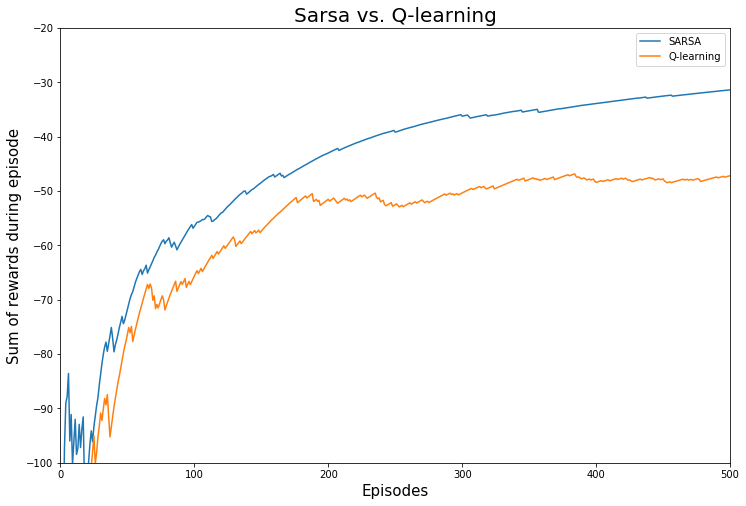

In [3]:
fig = plt.figure(1, figsize=(12,8))
plt.title('Sarsa vs. Q-learning', fontsize=20)
plt.xlabel('Episodes', fontsize=15)
plt.ylabel('Sum of rewards during episode', fontsize=15)
plt.plot(range(len(to_plot_sarsa)), to_plot_sarsa, label='SARSA')
plt.plot(range(len(to_plot_qlearning)), to_plot_qlearning, label='Q-learning')
plt.xlim((0, 500))
plt.ylim((-100,-20))
plt.legend()
plt.show()
fig.savefig('result.png')

## SARSA vs. Q-learning 비교 분석

위 그래프는 SARSA와 Q-learning의 online performance를 보여주고 있다. Q-learning은 전반적으로 SARSA에 비해 낮은 performance를 내고 있다. 이는 Q-learning이 bellman optimality equation을 directly update한다는 데 기여한다. Cliff Walking에서 optimal한 path는 cliff 바로 옆을 지나는 것이다. 그런데, 훈련에 사용되는 $\epsilon$-greedy policy는 $\epsilon$의 확률로 random action을 선택한다. Cliff 바로 옆을 지날 경우 $\epsilon$ greedy에 의해 cliff로 떨어지는 경우가 발생할 수 있다. 